In [1]:
from pathlib import Path
import os

if not "root" in locals():
    current_path = Path(os.getcwd())
    root = current_path.parent.absolute()

os.chdir(root)
print(root)
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from tam_expe.TinyAutoML import MetaPipelineCV
from tam_expe.TinyAutoML.Models import DemocraticModelCV, BestModelCV, OneRulerForAllCV

from MyTools.add_AR_cols import add_AR_cols
from data_treatment.box_creator import create_binary_box

/Users/g0bel1n/PycharmProjects/VIX_predictions


Here we import the whole cleaned dataset. It is 166 columns for 3692 rows.
We add Auto-lagged cols and the binary target

In [2]:
df = pd.read_csv('database.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = create_binary_box(df, relative_threshold = 0.05, box_length=5).set_index(['Date']).dropna(axis = 0)
df = add_AR_cols(df,7).dropna(axis = 0)
X,y = df.drop('Box', axis=1)[:'2020'], df['Box'][:'2020']

cut = int(len(y) * 0.8)

X_train, X_test = X[:cut], X[cut:]
y_train, y_test = y[:cut], y[cut:]

Then we instantiate the MetaPipeline object, we fit it and look at the outputs and scores.



In [3]:
print(X.index.dtype)



datetime64[ns]


In [5]:
mpipe = MetaPipelineCV(DemocraticModelCV(gridSearch=True))
mpipe.fit(X_train,y_train)

INFO:root:Training models...
  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


  0%|          | 0/4 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [6]:
mpipe.verbose

True

In [10]:
#mpipe.get_scores()
mpipe.classification_report(X_test,y_test)

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


              precision    recall  f1-score   support

           0       0.71      0.59      0.64       381
           1       0.61      0.73      0.67       339

    accuracy                           0.66       720
   macro avg       0.66      0.66      0.66       720
weighted avg       0.66      0.66      0.65       720



/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


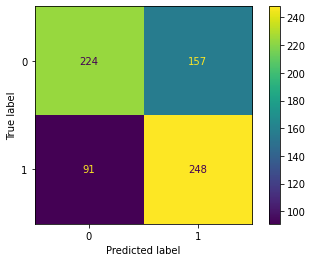

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test,mpipe.predict(X_test))

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


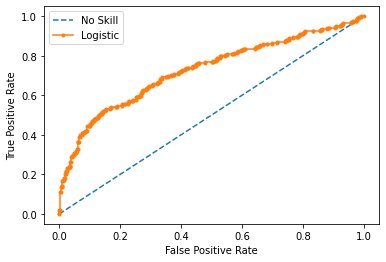

In [12]:
mpipe.roc_curve(X_test,y_test)

In [12]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,mpipe.predict(X_test))

INFO:root:Correcting non-stationarity on the dataset...
/Users/g0bel1n/PycharmProjects/pythonProject/basic_env/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.6888888888888889

In [ ]:
from matplotlib import pyplot as plt
from sklearn import tree


fig = plt.figure(figsize=(40,10))
_ = tree.plot_tree(mpipe.pipe.named_steps['orfa'].ruler,
                   label='root',
                   class_names= ['not up', 'up'],
                   filled=True)

In [13]:
import xgboost as xgb

clf = xgb.XGBClassifier(eval_metric='auc')
clf.fit(X_train,y_train)




/Users/g0bel1n/PycharmProjects/pythonProject/basic_env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
accuracy_score(y_test,clf.predict(X_test))
